In [1]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd "drive/My Drive"

/content/drive/My Drive


In [3]:
import os
import random
import sys
import warnings
from itertools import chain

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL.Image
import tensorflow as tf
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.core import Activation, Lambda
from keras.layers.merge import concatenate
from keras.layers.pooling import MaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing.image import (ImageDataGenerator, array_to_img,
                                       img_to_array, load_img)
from skimage.io import concatenate_images, imread, imshow
from skimage.morphology import label
from skimage.transform import resize
from tqdm import tnrange, tqdm_notebook

%matplotlib inline

Using TensorFlow backend.


In [0]:
# Set hyperparameters

# Shape
im_height = 256
im_width = 256
im_chan = 1

# Path
path_train = "new_dataset/train/rwanda/"
path_test = "new_dataset/test/rwanda/"

In [0]:
# Create lists of IDs where the total number is the number of images

train_ids = list(range(0, 50))
test_ids = list(range(0, 30))

In [6]:
# Resize
X_train = np.zeros(
    (len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), im_height, im_width, im_chan))

for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
    path = path_train

    # Original image
    img = load_img(path + "image_high_sharpened/" + str(id_) + ".png")
    # Get 1 channel from 3 channels, RGB
    x = img_to_array(img)[:, :, 1]
    x = resize(x, (im_height, im_width, 1),
               mode="constant", preserve_range=True)
    X_train[n] = x

    # Mask image
    mask = PIL.Image.open(path + "label/" + str(id_) + ".png")
    mask = np.asarray(mask)
    Y_train[n] = resize(mask, (im_height, im_width, 1),
                        mode="constant", preserve_range=True)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [0]:
# Define IoU metrics


def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [8]:
# Bulid U-Net model


def theacher_model():
    # Shape: (256, 256, 1)
    inputs = Input((im_height, im_width, im_chan))
    # Change pixel values to 0-1
    s = Lambda(lambda x: x / 255)(inputs)

    # Filter: (3✕3), Number of filters:8
    # N_out = (N_in + 2P - F)/s +1
    #       = (128 +0 - 2)/2 + 1
    #       = 64
    tc1 = Conv2D(8, (3, 3), activation='relu', padding='same')(s)
    tc1 = Conv2D(8, (3, 3), activation='relu', padding='same')(tc1)
    tp1 = MaxPooling2D((2, 2))(tc1)
    # Shape: (64,64,8)

    # N_in: (64,64,8)
    tc2 = Conv2D(16, (3, 3), activation='relu', padding='same')(tp1)
    tc2 = Conv2D(16, (3, 3), activation='relu', padding='same')(tc2)
    tp2 = MaxPooling2D((2, 2))(tc2)
    # N_out: (32,32,16)

    tc3 = Conv2D(32, (3, 3), activation='relu', padding='same')(tp2)
    tc3 = Conv2D(32, (3, 3), activation='relu', padding='same')(tc3)
    tp3 = MaxPooling2D((2, 2))(tc3)
    # N_out: (16, 16, 32)

    tc4 = Conv2D(64, (3, 3), activation='relu', padding='same')(tp3)
    tc4 = Conv2D(64, (3, 3), activation='relu', padding='same')(tc4)
    tp4 = MaxPooling2D(pool_size=(2, 2))(tc4)
    # N_out: (8,8,64)

    tc5 = Conv2D(128, (3, 3), activation='relu', padding='same')(tp4)
    tc5 = Conv2D(128, (3, 3), activation='relu', padding='same')(tc5)
    # N_out: (8, 8, 128)

    tu6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(tc5)
    tu6 = concatenate([tu6, tc4])
    tc6 = Conv2D(64, (3, 3), activation='relu', padding='same')(tu6)
    tc6 = Conv2D(64, (3, 3), activation='relu', padding='same')(tc6)
    # N_out: (16,16, 64)

    tu7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(tc6)
    tu7 = concatenate([tu7, tc3])
    tc7 = Conv2D(32, (3, 3), activation='relu', padding='same')(tu7)
    tc7 = Conv2D(32, (3, 3), activation='relu', padding='same')(tc7)
    # N_out: (32,32, 32)

    tu8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(tc7)
    tu8 = concatenate([tu8, tc2])
    tc8 = Conv2D(16, (3, 3), activation='relu', padding='same')(tu8)
    tc8 = Conv2D(16, (3, 3), activation='relu', padding='same')(tc8)
    # N_out: (64, 64, 16)

    tu9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same')(tc8)
    # N_out: (128, 128, 8)
    tu9 = concatenate([tu9, tc1], axis=3)
    tc9 = Conv2D(8, (3, 3), activation='relu', padding='same')(tu9)
    tc9 = Conv2D(8, (3, 3), activation='relu', padding='same')(tc9)

    tc10 = Conv2D(1, (1, 1))(tc9)
    teacher_outputs = Activation('sigmoid')(tc10)

    return Model(inputs=[inputs], outputs=[teacher_outputs])


t_model = theacher_model()
t_model.compile(optimizer='adam', loss='binary_crossentropy',
                metrics=[mean_iou])
t_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 8)  80          lambda_1[0][0]                   
_____________

In [9]:
# Fit

results = t_model.fit(
    X_train, Y_train, validation_split=0.1, batch_size=8, epochs=300)

Train on 45 samples, validate on 5 samples
Epoch 1/300
45/45 [==============================] - 5s 109ms/step - loss: 0.6778 - mean_iou: 0.3943 - val_loss: 0.6489 - val_mean_iou: 0.4832
Epoch 2/300
45/45 [==============================] - 0s 7ms/step - loss: 0.5832 - mean_iou: 0.4861 - val_loss: 0.3331 - val_mean_iou: 0.4871
Epoch 3/300
45/45 [==============================] - 0s 7ms/step - loss: 0.1968 - mean_iou: 0.4864 - val_loss: 0.1123 - val_mean_iou: 0.4877
Epoch 4/300
45/45 [==============================] - 0s 7ms/step - loss: 0.1061 - mean_iou: 0.4886 - val_loss: 0.1004 - val_mean_iou: 0.4894
Epoch 5/300
45/45 [==============================] - 0s 7ms/step - loss: 0.1018 - mean_iou: 0.4898 - val_loss: 0.0978 - val_mean_iou: 0.4904
Epoch 6/300
45/45 [==============================] - 0s 7ms/step - loss: 0.1027 - mean_iou: 0.4908 - val_loss: 0.0989 - val_mean_iou: 0.4910
Epoch 7/300
45/45 [==============================] - 0s 7ms/step - loss: 0.0945 - mean_iou: 0.4911 - val_loss

In [0]:
# Save

t_model.save("weight/teacher_model4.h5")

In [11]:
# Get and resize test images

X_test = np.zeros(
    (len(test_ids), im_height, im_width, im_chan), dtype=np.uint8)
sizes_test = []

sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(test_ids), total=len(test_ids)):
    path = path_test
    img = load_img(path + "/" + str(id_) + ".png")
    x = img_to_array(img)[:, :, 1]
    sizes_test.append([x.shape[0], x.shape[1]])
    x = resize(x, (im_height, im_width, 1),
               mode="constant", preserve_range=True)
    X_test[n] = x

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [12]:
# Predict

t_model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_train = t_model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = t_model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = t_model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

30/30 [==============================] - 1s 23ms/step


In [13]:
# Create a list of upsampled test masks

preds_test_upsampled = []
for i in tnrange(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]),
                                       (sizes_test[i][0], sizes_test[i][1]),
                                       mode='constant', preserve_range=True))

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Original Image


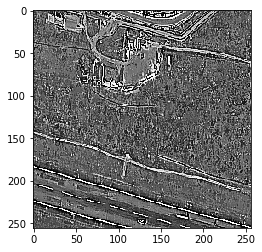

Label


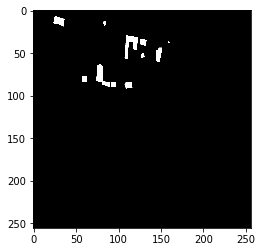

Prediction


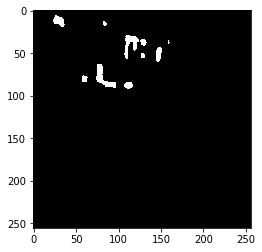

In [17]:
# Show a result on a random sample

# Original image
print("Original Image")
ix = random.randint(0, len(preds_train_t))
plt.imshow(np.dstack((X_train[ix], X_train[ix], X_train[ix])))
plt.show()

# Mask image
print("Label")
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp, tmp, tmp)))
plt.show()

# Prediction image
print("Prediction")
tmp = np.squeeze(preds_train_t[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp, tmp, tmp)))
plt.show()